# Lesson 8 Assignment - TimeseriesOpEd

## Author - Lawrence Huang



## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.tsa.seasonal as sts
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.graphics.tsaplots as splt

##### Load and examine data

In [2]:
# Load and examine data
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"
df = pd.read_csv(fileName)
df.head()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125


In [3]:
# Examine tail of dataframe
df.tail()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
223,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424
224,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625
225,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176
226,2013,Nov,1.865,61.394,3.275,1.7537,227,51529,11697083
227,2013,Dec,2.345,53.653,3.473,1.6747,228,51984,11852352


In [4]:
# Set index. From above, confirmed that the data runs from Jan 1995 to Dec 2013
df.index = pd.date_range(start='1-1-1995', end='12-31-2013', freq='M')
df.index

DatetimeIndex(['1995-01-31', '1995-02-28', '1995-03-31', '1995-04-30',
               '1995-05-31', '1995-06-30', '1995-07-31', '1995-08-31',
               '1995-09-30', '1995-10-31',
               ...
               '2013-03-31', '2013-04-30', '2013-05-31', '2013-06-30',
               '2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31'],
              dtype='datetime64[ns]', length=228, freq='M')

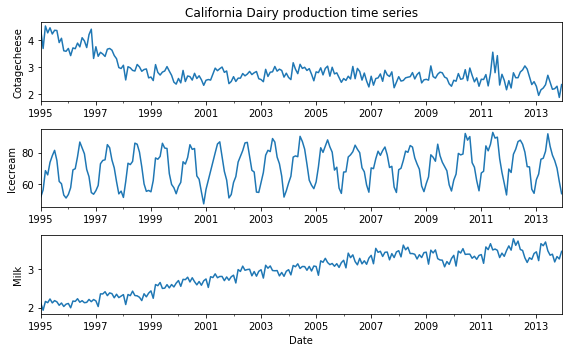

In [5]:
# Plot data, examine the 3 time series
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,5))
df['Cotagecheese.Prod'].plot(ax = ax1)
df['Icecream.Prod'].plot(ax = ax2)
df['Milk.Prod'].plot(ax = ax3)

ax1.set_ylabel('Cotagecheese')
ax2.set_ylabel('Icecream')
ax3.set_ylabel('Milk')
ax3.set_xlabel('Date')
ax1.set_title('California Dairy production time series')
f.tight_layout()
plt.show()

##### Time series analysis of milk production
<ul>
    <li>There appears to be a noticeable seasonal component.</li>
<li>The amplitude of the seasonal variation in milk production appears to grow with time (for example, seasonal variation appears higher between 2011 and 2013 compared to 2007 and 1995).</li>
    <li>Strategy: use a multiplicative decomposition model. The multiplicative model can be easily transformed to an additive model by taking the logarithm of the values. </li>
    </ul>

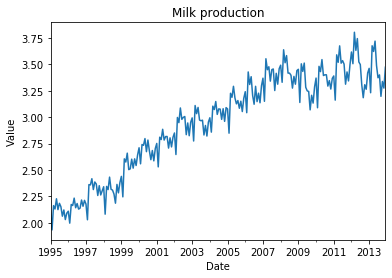

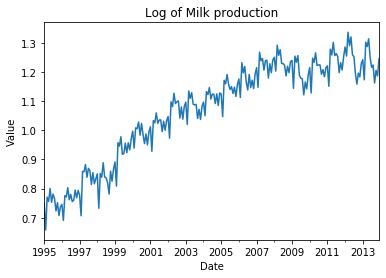

In [6]:
# log transform of milk production
df['Milk.Prod_log'] = np.log(df['Milk.Prod'])

# funciton to plot time series
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')

# compare plots before and after log transformation    
plot_ts(df['Milk.Prod'], 'Milk production')
plt.show()
plot_ts(df['Milk.Prod_log'], 'Log of Milk production')
plt.show()

##### Observation: <ul>
<li>After log transformation, the seasonal component has a more constant magnitude compared to the non-transformed series.</li></ul>

##### STL decomposition

In [7]:
# function to model the trend and a monthly seasonal component
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    #resplot = res.plot()
    res.plot()
    plt.suptitle('STL decomposition of Milk.Prod_log')
    plt.xlabel('Date')
    plt.subplots_adjust(top=0.9)
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index))

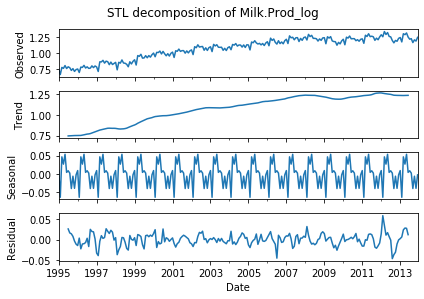

               resid     trend  seasonal
1995-01-31       NaN       NaN  0.009169
1995-02-28       NaN       NaN -0.063646
1995-03-31       NaN       NaN  0.046570
1995-04-30       NaN       NaN  0.026694
1995-05-31       NaN       NaN  0.053586
1995-06-30       NaN       NaN  0.004263
1995-07-31  0.026259  0.746283  0.008616
1995-08-31  0.016510  0.747581  0.002307
1995-09-30  0.014267  0.749151 -0.039741
1995-10-31  0.008047  0.750003 -0.006162
1995-11-30 -0.003504  0.750755 -0.039215
1995-12-31 -0.011135  0.751219 -0.002441
               resid     trend  seasonal
2013-01-31  0.002499  1.230179  0.009169
2013-02-28  0.006582  1.229856 -0.063646
2013-03-31  0.024035  1.231219  0.046570
2013-04-30  0.028554  1.231778  0.026694
2013-05-31  0.027831  1.232307  0.053586
2013-06-30  0.012240  1.233112  0.004263
2013-07-31       NaN       NaN  0.008616
2013-08-31       NaN       NaN  0.002307
2013-09-30       NaN       NaN -0.039741
2013-10-31       NaN       NaN -0.006162
2013-11-30      

In [8]:
# use multiplicative (log transformed) STL model as discussed above
milk_decomp = decomp_ts(df['Milk.Prod_log'])
plt.show()
print(milk_decomp.head(12))
print(milk_decomp.tail(12))

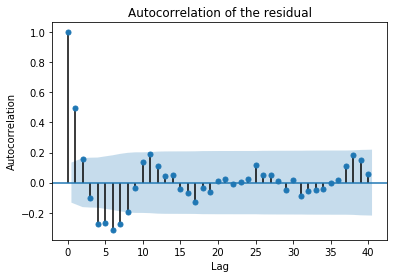

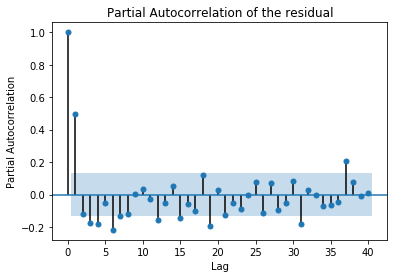

In [9]:
# plot the ACF and PACF for the remainder series
splt.plot_acf(milk_decomp.resid[6:-6], lags = 40)
plt.title('Autocorrelation of the residual')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

splt.plot_pacf(milk_decomp.resid[6:-6], lags = 40)
plt.title('Partial Autocorrelation of the residual')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

##### 1. Is this time series stationary?

In [10]:
# Use Dicky Fuller test to determine if the time series is stationary. 
# The null hypothesis is that the time series is not stationary, but with no trend.
from statsmodels.tsa.stattools import adfuller
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%'])) 

In [11]:
# Dicky Fuller test on original time series
DF_Test(df['Milk.Prod_log'])

D-F statistic = -2.317972641864474
p-value = 0.16623693720057064
number of lags used = 12
Critical value at 5% confidence = -2.875078880098608
Critical value at 10% confidence = -2.5739861168199027


In [12]:
# Dicky Fuller test on the residual
DF_Test(milk_decomp.resid[6:-6])

D-F statistic = -8.280935682685259
p-value = 4.521792223864596e-13
number of lags used = 7
Critical value at 5% confidence = -2.875537986778846
Critical value at 10% confidence = -2.574231080806213


##### Results: 
For the original time series Milk.Prod_log: we fail to reject the null hypothesis that it is not stationary (p>=0.05); i.e. it is not stationary.<br>

For the residual: we reject the null hypothesis that the it is not stationary (p<0.05); i.e. it is stationary. 

##### 2. Is there a significant seasonal component?

##### Results:

From the STL decomposition plots above, Milk.Prod_log has a noticeable seasonal component. Much of the seasonality has been removed by STL decomposition.

The ACF and PACF of the residual exhibit both AR and MA behavior but with some signs of remaining periodicity.

##### 3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

##### Compute an ARIMA model for the residual

In [13]:
# functions to find the best ARIMA model with the lowest BIC by iterating over a grid of p, d, and q values. 
# For each p, d, q combination the BIC is computed and compared to the best previous model.
def model_ARIMA_2(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.arima_model import ARIMAResults    
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)

def step_ARIMA(resid, p_max, d_max, q_max):
    from statsmodels.tsa.arima_model import ARIMAResults    
    from statsmodels.tsa.arima_model import ARIMA
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0):
                    try:
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model) 

In [14]:
# Find best model with the lowest BIC
BIC, order, model = step_ARIMA(milk_decomp.resid[6:-6], 4, 3, 4)    
print('***************************************')
print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))

Testing model of order: (0, 0, 1) with BIC = -1259.2535158002456
Testing model of order: (0, 0, 2) with BIC = -1263.3895258177872
Testing model of order: (0, 0, 3) with BIC = -1261.65898902056
Testing model of order: (0, 0, 4) with BIC = -1259.6340335043071
Testing model of order: (0, 1, 1) with BIC = -1208.1215115966227
Testing model of order: (0, 1, 2) with BIC = -1242.5518231300798
Testing model of order: (0, 1, 3) with BIC = -1246.9800717750684
Testing model of order: (0, 1, 4) with BIC = -1245.5268107373802
Testing model of order: (0, 2, 1) with BIC = -1188.1204125665993
Testing model of order: (1, 0, 0) with BIC = -1266.337871220621
Testing model of order: (1, 0, 1) with BIC = -1262.7075998773807
Testing model of order: (1, 0, 2) with BIC = -1259.395678185283
Testing model of order: (1, 1, 0) with BIC = -1206.0860866049395
Testing model of order: (1, 2, 0) with BIC = -1085.33203648243
Testing model of order: (2, 0, 0) with BIC = -1263.784872165231
Testing model of order: (2, 0, 1

##### Results: 

The order of the ARMA(p,q) process that best fits the residual: p=2, q=1.

In [15]:
# function to return model fit summary
def model_ARIMA(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    print(model_fit.summary())
    return(model_fit)

In [16]:
# view summary of a model of the best order.
model_ARIMA(milk_decomp.resid[6:-6], order=order)

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  216
Model:                     ARMA(2, 1)   Log Likelihood                 658.121
Method:                           mle   S.D. of innovations              0.011
Date:                Thu, 08 Aug 2019   AIC                          -1308.241
Time:                        17:21:03   BIC                          -1294.740
Sample:                    07-31-1995   HQIC                         -1302.787
                         - 06-30-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.resid     1.4072      0.055     25.587      0.000       1.299       1.515
ar.L2.resid    -0.6030      0.055    -10.956      0.000      -0.711      -0.495
ma.L1.resid    -0.9787      0.014    -67.773    

##### Observation:

All coefficients for the ARMA(2,1) model are significant.

##### Forecast production for 12 months and report both numeric values and plot the confidence intervals

Strategy:
<ul>
<li>Hold back the last 12 months of data for testing/evaluating the model. Use the rest for training the model.</li>
    <li>Create new dummy (binary) variables for the months. These features, along with the count of months (and squared and cubed of the count of months) are used to model the seasonal variation using a linear regression model.</li>
    
<li>Use an ARIMA model for the residuals.</li>
<li>Forecast a 12 month period by combining the trend, seasonal and residual models.</li>
    
</ul>

In [17]:
# Normalize the time features (standardize using z-score)
df.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed']] = df.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed']].apply(zscore)

# Create dummy variables for the months
years = int(len(df['Milk.Prod_log'])/12)
df.loc[:, 'Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * years
dummies = pd.get_dummies(df.loc[:, 'Month'])
df[list(dummies.columns)] = dummies

# Print the head of the dataframe to look at the dummy variables.
df.head(12)

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,Milk.Prod_log,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
1995-01-31,1995,Jan,4.370,51.595,2.112,0.9803,-1.724471,-1.120740,-0.883649,0.747635,...,0,0,1,0,0,0,0,0,0,0
1995-02-28,1995,Feb,3.695,56.086,1.932,0.8924,-1.709277,-1.120548,-0.883646,0.658556,...,0,1,0,0,0,0,0,0,0,0
1995-03-31,1995,Mar,4.538,68.453,2.162,0.8924,-1.694084,-1.120226,-0.883641,0.771034,...,0,0,0,0,0,1,0,0,0,0
1995-04-30,1995,Apr,4.280,65.722,2.130,0.8967,-1.678890,-1.119776,-0.883630,0.756122,...,0,0,0,0,0,0,0,0,0,0
1995-05-31,1995,May,4.470,73.730,2.227,0.8967,-1.663696,-1.119198,-0.883612,0.800655,...,0,0,0,0,0,0,1,0,0,0
1995-06-30,1995,Jun,4.238,77.994,2.124,0.9160,-1.648503,-1.118491,-0.883585,0.753301,...,0,0,0,0,1,0,0,0,0,0
1995-07-31,1995,Jul,4.377,81.475,2.184,0.9160,-1.633309,-1.117656,-0.883547,0.781158,...,0,0,0,1,0,0,0,0,0,0
1995-08-31,1995,Aug,4.368,74.981,2.152,0.8934,-1.618116,-1.116692,-0.883497,0.766398,...,0,0,0,0,0,0,0,0,0,0
1995-09-30,1995,Sep,3.917,61.530,2.062,0.8934,-1.602922,-1.115600,-0.883433,0.723676,...,0,0,0,0,0,0,0,0,0,1
1995-10-31,1995,Oct,4.078,60.022,2.121,0.9434,-1.587729,-1.114379,-0.883353,0.751888,...,0,0,0,0,0,0,0,0,1,0


##### Linear regression model for trend and seasonal variation. 

Note that an intercept is not needed for the seasonal component, which is a categorical feature.

Predictions of the trend and seasonal values are computed.<br>
The residuals with respect to these predictions are computed.

In [18]:
# Define features (X) and target (Y) arrays and fit the model
X = df.loc[:'2012-12-31', ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
Y = df.loc[:'2012-12-31', 'Milk.Prod_log'].as_matrix()
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, Y)

## and the predictions and the residual
df.loc[:'2012-12-31', 'scores'] = mod_fit.predict(X)
df.loc[:'2012-12-31', 'resids'] = df.loc[:'2012-12-31', 'scores'] - df.loc[:'2012-12-31', 'Milk.Prod_log']

/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# function to plot the actual time series in red and the values predicted by the trend and seasonal model in blue
def plot_mod_fit(df, col):
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax, label='observed')
    df.loc[:, 'scores'].plot(ax = ax, label='predicted') 
    ax.set_title('Actual ' + col + ' vs. the predicted values') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
    ax.legend()

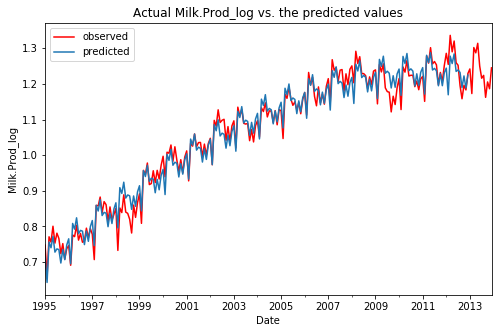

In [20]:
# examine results from linear regression of trend and seasonal variation
plot_mod_fit(df, 'Milk.Prod_log')  

In [21]:
# compute margin of error for 95% confidence interval for linear regression
# find total number of samples
n = df.shape[0]
xx = np.arange(n)
# find standard deviation of the residuals
stdev_resids = np.sqrt(np.sum((Y - mod_fit.predict(X)) ** 2)/(n-2))
# find margin of error, using z=1.96 for 95% confidence interval
me_linreg = [1.96*stdev_resids*np.sqrt((1/n)+((x-np.mean(xx))**2)/((n-1)*np.var(xx))) for x in xx]

In [22]:
# function to compute root mean squared error between the predicted and actual values
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

In [23]:
# Make the forecast for the next 12 months
# train was till December 2012.
X = df.loc['2013-1-31':, ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
# Compute the RMSE
print('RMSE: {}'.format(RMSE(df.loc['2013-1-31':, 'Milk.Prod_log'].as_matrix(), mod_fit.predict(X))))

RMSE: 0.13736021560118697


/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """



<ul>
    <li>Trend and seasonal components fit the actual data fairly well.</li>
    </ul>

##### Examine the residual time series

In [24]:
# function to plot histogram and Q-Q normal plot of the residual
def dist_ts(ts, lab = '', bins = 40):
    import scipy.stats as ss
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)
    f.tight_layout()

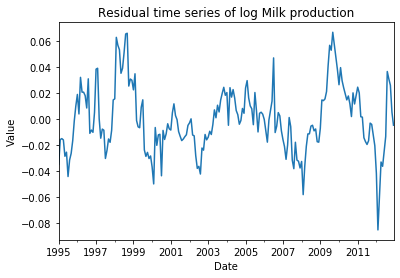

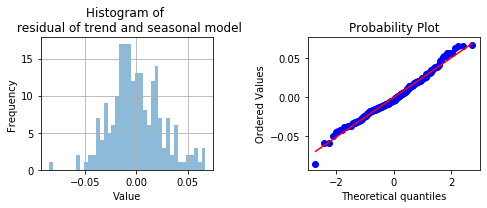

In [25]:
# plot residual
plot_ts(df.loc[:'2012-12-31', 'resids'], title = 'Residual time series of log Milk production')
# plot residual distribution and Q-Q normal plot
dist_ts(df.loc[:'2012-12-31', 'resids'], '\n residual of trend and seasonal model')

In [26]:
# Dicky Fuller test on the residual
DF_Test(df.loc[:'2012-12-31', 'resids'])

D-F statistic = -4.629902367773566
p-value = 0.00011373279240861113
number of lags used = 0
Critical value at 5% confidence = -2.875078880098608
Critical value at 10% confidence = -2.5739861168199027


##### Observations:
<ul>
<li>The distribution of the residual is fairly close to a normal distribution, but with some (noticable) skew.</li>
    <li>The residual is stationary by Dicky Fuller test.</li>
</ul>

##### ARIMA model for the residual

In [27]:
# Find best model with the lowest BIC
BIC, order, model_fit = step_ARIMA(df.loc[:'2012-12-31', 'resids'], 4, 3, 4)    
print('***************************************')
print('Best order = ' + str(order) + ' best BIC = ' + str(BIC))

Testing model of order: (0, 0, 1) with BIC = -1103.4886428275638
Testing model of order: (0, 0, 2) with BIC = -1147.8577829473882
Testing model of order: (0, 0, 3) with BIC = -1178.1580917838412
Testing model of order: (0, 0, 4) with BIC = -1177.0042964063057
Testing model of order: (0, 1, 1) with BIC = -1189.025327325722
Testing model of order: (0, 1, 2) with BIC = -1184.7026263574303
Testing model of order: (0, 1, 3) with BIC = -1180.7590742942573
Testing model of order: (0, 1, 4) with BIC = -1178.823078365829
Testing model of order: (0, 2, 1) with BIC = -1173.4669644983412
Testing model of order: (1, 0, 0) with BIC = -1209.6064524461403
Testing model of order: (1, 0, 1) with BIC = -1204.5577163647893
Testing model of order: (1, 0, 2) with BIC = -1199.2801689347625
Testing model of order: (1, 0, 3) with BIC = -1193.9246905246578
Testing model of order: (1, 0, 4) with BIC = -1189.5470817402918
Testing model of order: (1, 1, 0) with BIC = -1188.5917739983836
Testing model of order: (1,

/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing model of order: (1, 2, 2) with BIC = -1173.6041445587935
Testing model of order: (1, 2, 3) with BIC = -1161.9265111513034
Testing model of order: (2, 0, 0) with BIC = -1204.5726170928679
Testing model of order: (2, 0, 1) with BIC = -1199.228636348981
Testing model of order: (2, 0, 2) with BIC = -1193.9075274790102
Testing model of order: (2, 0, 3) with BIC = -1189.6750244322823
Testing model of order: (2, 0, 4) with BIC = -1186.158131334185
Testing model of order: (2, 1, 0) with BIC = -1183.9146276085658
Testing model of order: (2, 1, 1) with BIC = -1190.7828551224331
Testing model of order: (2, 1, 2) with BIC = -1185.1441867413348
Testing model of order: (2, 2, 0) with BIC = -1101.0243215270093
Testing model of order: (2, 2, 1) with BIC = -1166.3055872328446
Testing model of order: (2, 2, 2) with BIC = -1161.768605771572


/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (2, 2, 3) with BIC = -1169.882889285322


/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (2, 2, 4) with BIC = -1155.5661309856232
Testing model of order: (3, 0, 0) with BIC = -1199.2661566171719
Testing model of order: (3, 0, 1) with BIC = -1193.8915277458977
Testing model of order: (3, 0, 2) with BIC = -1198.2435899152667
Testing model of order: (3, 0, 3) with BIC = -1186.1070015574414
Testing model of order: (3, 0, 4) with BIC = -1181.6926442715521
Testing model of order: (3, 1, 0) with BIC = -1179.4869234924302
Testing model of order: (3, 1, 1) with BIC = -1185.4505162508215
Testing model of order: (3, 1, 2) with BIC = -1180.738823840658
Testing model of order: (3, 2, 0) with BIC = -1104.950957496063
Testing model of order: (3, 2, 1) with BIC = -1161.7584186353167
Testing model of order: (3, 2, 2) with BIC = -1156.402789536215


/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing model of order: (3, 2, 3) with BIC = -1153.7773481451995


/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (3, 2, 4) with BIC = -1149.8379761929043
Testing model of order: (4, 0, 0) with BIC = -1193.8967294058918
Testing model of order: (4, 0, 1) with BIC = -1190.1867452845363
Testing model of order: (4, 0, 2) with BIC = -1199.1297226561294
Testing model of order: (4, 0, 3) with BIC = -1189.4687909734796
Testing model of order: (4, 0, 4) with BIC = -1185.1525249573467
Testing model of order: (4, 1, 0) with BIC = -1178.357502605489
Testing model of order: (4, 1, 1) with BIC = -1174.4355692555323
Testing model of order: (4, 1, 2) with BIC = -1169.1305316032224
Testing model of order: (4, 1, 3) with BIC = -1177.7763985547124
Testing model of order: (4, 1, 4) with BIC = -1162.0451995020662
Testing model of order: (4, 2, 0) with BIC = -1125.7915503116817
Testing model of order: (4, 2, 1) with BIC = -1160.373654479782
Testing model of order: (4, 2, 2) with BIC = -1156.537726198023
Testing model of order: (4, 2, 3) with BIC = -1151.2649056591424
Testing model of order: (4, 

/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [28]:
# arima model for residual
arima_remainder = model_ARIMA(df.loc[:'2012-12-31', 'resids'], order = order)

# use ARIMA model to make predictions for the last 12 months
start_index = len(df.loc[:'2012-12-31', 'resids']) 
end_index = start_index + 11
model_prediction = arima_remainder.predict(start=start_index, end=end_index)
print('\nmodel prediction:\n{}'.format(model_prediction))

                              ARMA Model Results                              
Dep. Variable:                 resids   No. Observations:                  216
Model:                     ARMA(1, 0)   Log Likelihood                 610.179
Method:                           mle   S.D. of innovations              0.014
Date:                Thu, 08 Aug 2019   AIC                          -1216.357
Time:                        17:21:19   BIC                          -1209.606
Sample:                    01-31-1995   HQIC                         -1213.630
                         - 12-31-2012                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.resids     0.8248      0.038     21.617      0.000       0.750       0.900
                                    Roots                                    
                  Real          Imaginary      

In [29]:
# Combine the trend, seasonal, and residual (ARIMA) models. (Using minus since output from residual model is negative.)
# Make the forecast for the next year
X = df.loc['2013-1-31':, ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
# and the predictions for the forecast
# df.loc['2013-1-31':, 'scores'] =  mod_fit.predict(X) #without combining arima model
df.loc['2013-1-31':, 'scores'] =  mod_fit.predict(X) - model_prediction

/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


RMSE for combined prediction: 0.1366535777638561


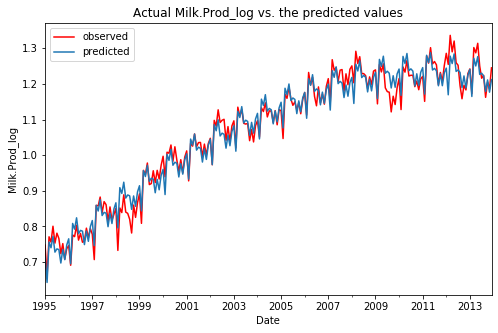

In [30]:
# plot actual vs. predicted milk production
plot_mod_fit(df, 'Milk.Prod_log') 

# compute RMSE
print('RMSE for combined prediction: {}'.format(RMSE(df.loc['2013-1-31':, 'Milk.Prod_log'].as_matrix(), df.loc['2013-1-31':, 'scores'])))

<ul><li>Adding the ARIMA component for the residual decreased RMSE and thus improved overall model prediction, but the change was minimal. </ul></li>

In [31]:
# margin of error for 95% confidence interval for arima prediction for the last 12 months
# ci for arima prediction
preds, stderr, ci = arima_remainder.forecast(12)
# get the margin of error from ci to combine with the linear regression model
me_arima = [ci[xx][1]-preds[xx] for xx in range(len(preds))]

# combined margin of error for 95% confidence interval (linear regression and arima)
me_total = np.array(me_linreg[-12:])+np.array(me_arima)

##### Report numeric values and plot the confidence intervals

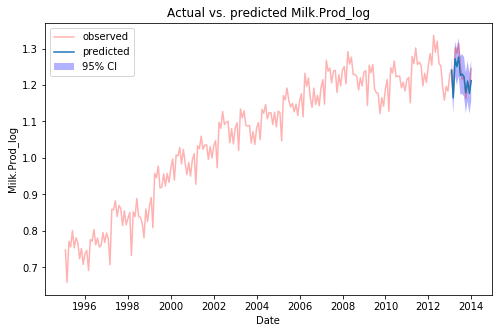

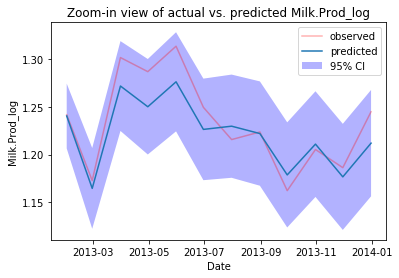

In [32]:
# plot observed, predicted with 95% confidence interval
df_plot = df.copy()[['Milk.Prod_log', 'scores']]
df_plot.loc['2013-1-31':, 'upper'] = df_plot.loc['2013-1-31':, 'scores']+me_total
df_plot.loc['2013-1-31':, 'lower'] = df_plot.loc['2013-1-31':, 'scores']-me_total

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df_plot.index, df_plot['Milk.Prod_log'], 'r', alpha=0.3, label='observed')
ax.plot(df_plot.index[-12:], df['scores'][-12:], label='predicted')
ax.fill_between(df_plot.index, df_plot['lower'], df_plot['upper'], facecolor='b', alpha=0.3, label='95% CI')
ax.set_xlabel('Date')
ax.set_ylabel('Milk.Prod_log')
ax.legend()
ax.set_title('Actual vs. predicted Milk.Prod_log')
plt.show()

# replot, focusing on last 12 months
fig, ax = plt.subplots()
ax.plot(df_plot.index[-12:], df_plot['Milk.Prod_log'][-12:], 'r', alpha=0.3, label='observed')
ax.plot(df_plot.index[-12:], df['scores'][-12:], label='predicted')
ax.fill_between(df_plot.index, df_plot['lower'], df_plot['upper'], facecolor='b', alpha=0.3, label='95% CI')
ax.set_xlabel('Date')
ax.set_ylabel('Milk.Prod_log')
ax.legend()
ax.set_title('Zoom-in view of actual vs. predicted Milk.Prod_log')
plt.show()

In [33]:
# prediction and confidence intervals
print('scores: prediction\n(lower, upper): 95% CI')
df_plot[-12:]

scores: prediction
(lower, upper): 95% CI


,Milk.Prod_log,scores,upper,lower
2013-01-31,1.241846,1.240542,1.274556,1.206527
2013-02-28,1.172792,1.164584,1.206952,1.122215
2013-03-31,1.301825,1.271955,1.319070,1.224840
2013-04-30,1.287026,1.250213,1.300285,1.200142
2013-05-31,1.313724,1.276388,1.328378,1.224398
2013-06-30,1.249615,1.226458,1.279724,1.173192
2013-07-31,1.215803,1.229837,1.283966,1.175707
2013-08-31,1.223775,1.222101,1.276823,1.167378
2013-09-30,1.162213,1.178729,1.233865,1.123592
2013-10-31,1.205372,1.211032,1.266461,1.155603


##### 1. Are the confidence intervals reasonably small compared to the forecast means?

In [34]:
# compare margin or error for 95% confidence interval to forecast values
print('margin of error compared to forecast values:')
print(me_total/df.tail(12)['scores'])

# compare margin or error for 95% confidence interval to forecast means
print('\nmargin of error compared to forecast mean:')
print(me_total/df.tail(12)['scores'].mean())

margin of error compared to forecast values:
2013-01-31    0.027419
2013-02-28    0.036381
2013-03-31    0.037042
2013-04-30    0.040050
2013-05-31    0.040732
2013-06-30    0.043431
2013-07-31    0.044014
2013-08-31    0.044778
2013-09-30    0.046776
2013-10-31    0.045770
2013-11-30    0.047287
2013-12-31    0.046037
Freq: M, Name: scores, dtype: float64

margin of error compared to forecast mean:
[0.02784174 0.03467973 0.03856483 0.04098435 0.04255493 0.0435995
 0.04430632 0.04479173 0.04513013 0.04537014 0.04554393 0.04567303]


The 95% confidence intervals are reasonably small, on the order of +/- 3-5% (or ~6-10% for the total interval) compared to forecast values or forecast mean.

##### 2. How do the confidence intervals behave as time moves to the future?

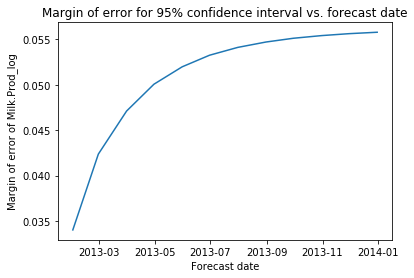

In [35]:
# plot margin of error for 95% confidence intervals vs. time
plt.plot(df_plot.index[-12:], me_total)
plt.title('Margin of error for 95% confidence interval vs. forecast date')
plt.xlabel('Forecast date')
plt.ylabel('Margin of error of Milk.Prod_log')
plt.show()

The confidence intervals (2 times the margin of error plotted above) increase as time moves into the future; predictions become less precise as time moves into the future.